In [13]:
from IPython import get_ipython
ipython = get_ipython()
if '__IPYTHON__' in globals():
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

import argparse
import os
from glob import glob
import pickle
from itertools import compress

%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.io import loadmat

import tensorflow as tf


from mymodels.macromicro_conv_model import load_matlab, shifted_zscore, print_metric, zscore

def minmax(x, inverse=False):
    xmin = np.array([-1,-1,6.8,-1])
    xmax = np.array([4000.,4000.,8.,4000.])
    
    a = xmax - xmin

    if inverse:
        x = x*a + xmin
    else:
        x = (x-xmin)/a

    return x

# normalize_data = minmax
# revert_data = lambda x: minmax(x, inverse=True)

# normalize_data = shifted_zscore
# revert_data = lambda x: shifted_zscore(x, inverse=True)

# normalize_data = zscore
# revert_data = lambda x: zscore(x, inverse=True)

normalize_data = lambda x: x
revert_data = lambda x: x


In [9]:
# shifted_zscore(np.array([2.89606,2.89606,2.89606,2.89606])/4, inverse=True)
shifted_zscore(np.array([2500,2500,7.5,2500])/4)

array([ 9.26681881,  9.26681856, -7.31488353,  9.26681886])

In [10]:
npdt = np.float32

names = ['DA', '5HT', 'pH', 'NE']
# prefix = '/mnt/nfs/proj/in-vitro/iterate/results_014/model_style_008/training-A-RBE-97Hz/'
prefix = '/mnt/nfs/proj/in-vitro/iterate/results_014/model_style_008/training-B-RBE025-97Hz/'

probes = ['MMA003W01R04', 'MMA004W01R04', 'MMA013W01R04', 'MMA018W01R04', 'MMA019W01R04', 'MMA022W01R04', 'MMA023W01R04', 'MMA024W01R04', 'MMA025W01R04']
# good_probes = ['MMA003W01R04', 'MMA004W01R04', 'MMA013W01R04', 'MMA019W01R04', 'MMA022W01R04', 'MMA024W01R04', 'MMA025W01R04']
good_probes = probes
filter_files = lambda x : x.find('500kohm') == -1

# probes = ['MMA003W01R04', 'MMA004W01R04', 'MMA013W01R04', 'MMA018W01R04', 'MMA019W01R04', 'MMA022W01R04'] # 500 kohms
# good_probes = probes
# filter_files = lambda x : x.find('500kohm') > -1


In [11]:

nrecords_per_session = 300

voltammograms = glob(prefix + '/*MMA*/voltammograms.mat')
print('number of voltammograms files %d'%len(voltammograms))
if not filter_files is None:
    voltammograms = list(compress(voltammograms, [filter_files(x) for x in voltammograms]))
print('after filter %d'%len(voltammograms))
print()

probe_data = {}
last_conc = None
for (iprobe, probe) in enumerate(probes):
    probe_files = voltammograms.copy()
    probe_files = list(compress(probe_files, [x.find(probe) > -1 for x in probe_files]))
    print('number of probe %s''s files: %d'%(probe, len(probe_files)), flush=True)
    probe_x, probe_y = load_matlab(probe_files, nrecords_per_session, split=1., asnumpy=True, proj_y=normalize_data)

    print(probe_x.shape, probe_y.shape)
    ul, ulidx = np.unique(probe_y, return_index=True, axis=0)
    if last_conc is not None:
        if np.any(ul.flatten() - last_conc.flatten()):
            print('%s different'%probe)
        last_conb = ul
    else:
        last_conc = ul
    
    probe_data[probe] = (probe_x, probe_y)


number of voltammograms files 36
after filter 36

number of probe MMA003W01R04s files: 4
(39600, 999)
(39600, 4)
(39600, 999) (39600, 4)
number of probe MMA004W01R04s files: 4
(39600, 999)
(39600, 4)
(39600, 999) (39600, 4)
number of probe MMA013W01R04s files: 4
(39600, 999)
(39600, 4)
(39600, 999) (39600, 4)
number of probe MMA018W01R04s files: 4
(39600, 999)
(39600, 4)
(39600, 999) (39600, 4)
number of probe MMA019W01R04s files: 4
(39600, 999)
(39600, 4)
(39600, 999) (39600, 4)
number of probe MMA022W01R04s files: 4
(39600, 999)
(39600, 4)
(39600, 999) (39600, 4)
number of probe MMA023W01R04s files: 4
(39600, 999)
(39600, 4)
(39600, 999) (39600, 4)
number of probe MMA024W01R04s files: 4
(39600, 999)
(39600, 4)
(39600, 999) (39600, 4)
number of probe MMA025W01R04s files: 4
(39600, 999)
(39600, 4)
(39600, 999) (39600, 4)


In [18]:
import time

fig, axs = plt.subplots(tight_layout=True, figsize=(12, 5))

# fig,ax = plt.subplots(1,1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

# def pltsin(ax, colors=['b']):
#     x = np.linspace(0,1,100)
#     if ax.lines:
#         for line in ax.lines:
#             line.set_xdata(x)
#             y = np.random.random(size=(100,1))
#             line.set_ydata(y)
#     else:
#         for color in colors:
#             y = np.random.random(size=(100,1))
#             ax.plot(x, y, color)
#     fig.canvas.draw()
    
# fig,ax = plt.subplots(1,1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
# for f in range(5):
#     pltsin(ax, ['b', 'r'])
#     time.sleep(1)
    

plot_data = np.zeros((list(probe_data.values())[0][0].shape[1], len(good_probes)))
for (iprobe, probe) in enumerate(good_probes):
    probe_x, probe_y = probe_data[probe]
    ul, ulidx = np.unique(probe_y, return_index=True, axis=0)
    plot_data[:,iprobe] = np.mean(probe_x[ulidx,:], axis=0)

axs.plot(plot_data)
# axs.set_ylim(-50, 50)

# for shift in range(0,900,5):
#     axs.plot(plot_data[:,shift:shift+40], label=probe)
#     plt.draw()
#     time.sleep(.5)
axs.legend(good_probes)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
for (iprobe, probe) in enumerate(good_probes):
    probe_x, probe_y = probe_data[probe]

    ul, ulidx = np.unique(probe_y, return_index=True, axis=0)
    
    fig, axs = plt.subplots(tight_layout=True, figsize=(12, 5))

    for idx in ulidx:
        axs.plot(probe_x[idx,:])
    axs.set_title(probe)
#     axs[iprobe].set_ylim(-50, 50)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

MMA003W01R04 [-9.4523779e+03 -9.4524736e+03  4.2099996e+00 -9.4524160e+03]
MMA003W01R04 [1.0397461e+03 1.0397556e+03 3.1908679e-01 1.0397499e+03]

MMA004W01R04 [-9.4526260e+03 -9.4525010e+03  4.2099996e+00 -9.4528340e+03]
MMA004W01R04 [1.0397694e+03 1.0397570e+03 3.1908679e-01 1.0397903e+03]

MMA013W01R04 [-9.4526797e+03 -9.4525918e+03  4.2099996e+00 -9.4525947e+03]
MMA013W01R04 [1.0397756e+03 1.0397668e+03 3.1908679e-01 1.0397671e+03]

MMA018W01R04 [-9.4526650e+03 -9.4525146e+03  4.2099996e+00 -9.4527832e+03]
MMA018W01R04 [1.0397733e+03 1.0397583e+03 3.1908679e-01 1.0397852e+03]

MMA019W01R04 [-9.4526260e+03 -9.4525010e+03  4.2099996e+00 -9.4528340e+03]
MMA019W01R04 [1.0397694e+03 1.0397570e+03 3.1908679e-01 1.0397903e+03]

MMA022W01R04 [-9.4525205e+03 -9.4525527e+03  4.2099996e+00 -9.4525352e+03]
MMA022W01R04 [1.0397604e+03 1.0397635e+03 3.1908679e-01 1.0397618e+03]

MMA023W01R04 [-9.4523213e+03 -9.4524355e+03  4.2099996e+00 -9.4524072e+03]
MMA023W01R04 [1.0397405e+03 1.0397518e+03 3

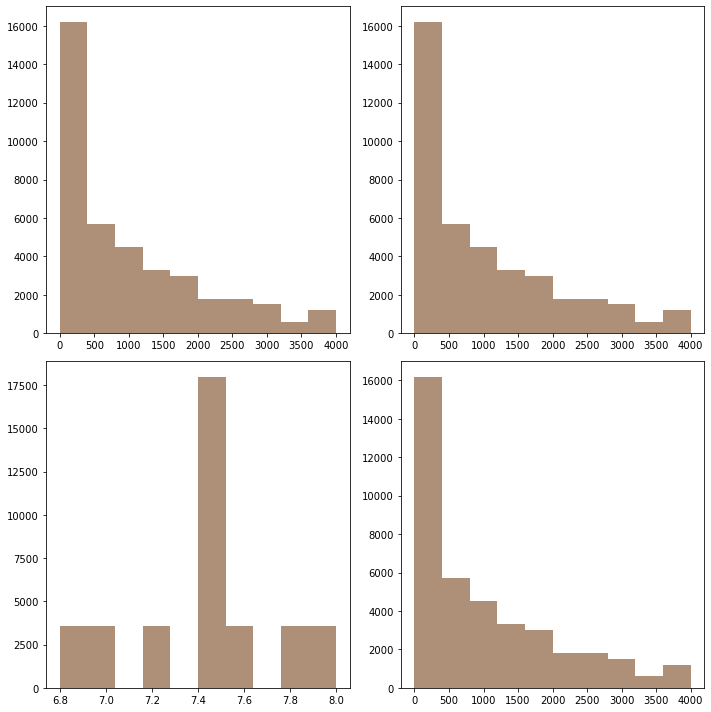

In [12]:
fig, axs = plt.subplots(2, 2, sharey=False, sharex=False, tight_layout=True)
fig.set_size_inches(10,10)

last_probe_y = None
for probe in good_probes:
    _ , probe_y = probe_data[probe]

#     print(probe, np.mean(probe_y, axis=0))
#     print(probe, np.std(probe_y, axis=0))
    
    std = np.std(probe_y, axis=0)
    print(probe, np.mean(probe_y, axis=0)-10*std)
    print(probe, std)

    print()

#     zeros = normalize_data(np.zeros(4))
    for ic in range(0,4):
        idx = np.unravel_index(ic, axs.shape)
        x = probe_y[:,ic]
        axs[idx].hist(x, alpha=.2)

In [8]:
np.sqrt(288992.4375)

537.5801684400197

In [9]:
(693.100830078125 + 639.6287231445312 + 7.405788421630859 + 516.1419677734375)/4

464.06932735443115